<a href="https://colab.research.google.com/github/ramesh112/capstone-final/blob/main/capstone_final_banking_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone: Credit Card Fraud EDA and Baseline Model

This notebook performs exploratory data analysis (EDA) and baseline modeling on a credit‑card transaction dataset to detect fraudulent transactions. The dataset contains eight variables describing transaction context and a binary target label indicating whether a transaction is fraudulent. The goals are to understand key patterns in the data, engineer useful features, and build an initial machine learning model that can distinguish fraud from non‑fraud.

## Data description

The dataset includes the following columns:

- `distance_from_home`  
- `distance_from_last_transaction`  
- `ratio_to_median_purchase_price`  
- `repeat_retailer`  
- `used_chip`  
- `used_pin_number`  
- `online_order`  
- `fraud` (target, 0 = non‑fraud, 1 = fraud)

The input features are numeric or binary indicators, while `fraud` is a 0/1 label identifying fraudulent transactions. In a typical 200,000‑row working sample, the fraud rate is around 8–9%, indicating a moderately imbalanced classification problem.

## Notebook outline

1. Setup and data loading  
2. Data checks and cleaning  
3. Visual EDA  
4. Feature engineering  
5. Baseline ML model and evaluation  
6. Summary and next steps


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.0)

# Load data (sample if very large)
df = pd.read_csv("data/card_data.csv")
df["fraud"] = df["fraud"].astype(int)

print("Shape:", df.shape)
print("Fraud rate:", df["fraud"].mean())

os.makedirs("figures", exist_ok=True)
df.head()

Shape: (500000, 8)
Fraud rate: 0.087506


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,3.660608,0.109027,4.304168,1.0,0.0,0.0,1.0,1
1,0.793127,1.554017,0.734684,0.0,0.0,0.0,1.0,0
2,1.446629,1.060293,0.621182,0.0,0.0,0.0,1.0,0
3,1.323360,0.468005,0.425015,0.0,1.0,0.0,0.0,0
4,9.729656,12.446111,4.245820,1.0,1.0,0.0,1.0,1


In [ ]:
# Basic info
print("Dtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())

# Descriptive statistics
df.describe()

Dtypes:
 distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
repeat_retailer                   float64
used_chip                         float64
used_pin_number                   float64
online_order                      float64
fraud                               int64
dtype: object

Missing values:
 distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,26.557296,5.032679,1.826252,0.881420,0.350096,0.100134,0.650256,0.087506
std,66.470931,27.414842,2.828105,0.323294,0.477000,0.300179,0.476889,0.282575
min,0.024461,0.000298,0.005741,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.873717,0.296774,0.476812,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.965503,0.997692,1.001161,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.685375,3.359875,2.099544,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Inspect upper quantiles for potential outliers
df[["distance_from_home",
    "distance_from_last_transaction",
    "ratio_to_median_purchase_price"]].quantile([0.95, 0.99, 0.999])

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price
0.950,99.337119,19.193602,6.059094
0.990,257.656632,65.622050,12.820214
0.999,747.400863,265.956671,29.711702


In [ ]:
# Optional: cap extreme outliers at the 99th percentile
df["distance_from_home_capped"] = df["distance_from_home"].clip(
    upper=df["distance_from_home"].quantile(0.99)
)
df["distance_from_last_transaction_capped"] = df["distance_from_last_transaction"].clip(
    upper=df["distance_from_last_transaction"].quantile(0.99)
)
df["ratio_to_median_purchase_price_capped"] = df["ratio_to_median_purchase_price"].clip(
    upper=df["ratio_to_median_purchase_price"].quantile(0.99)
)

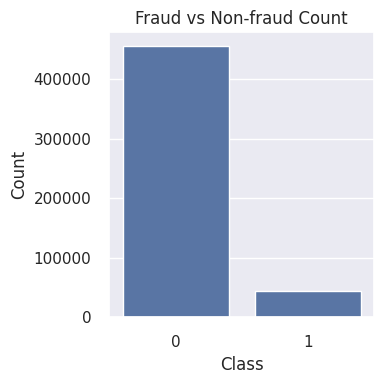

Fraud rate: 8.751%


In [ ]:
# Target distribution
plt.figure(figsize=(4, 4))
ax = sns.countplot(x="fraud", data=df)
ax.set_xlabel("Class")
ax.set_ylabel("Count")
ax.set_title("Fraud vs Non-fraud Count")
plt.tight_layout()
plt.savefig("figures/fraud_class_counts.png", dpi=150)
plt.show()

fraud_rate = df["fraud"].mean()
print(f"Fraud rate: {fraud_rate:.3%}")

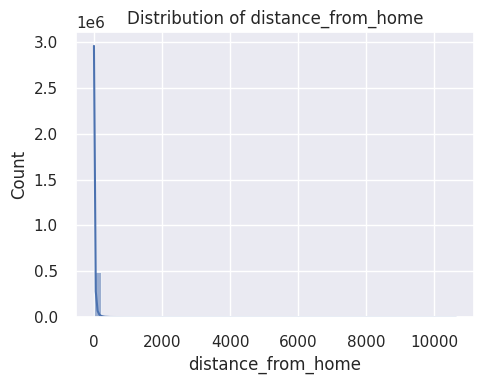

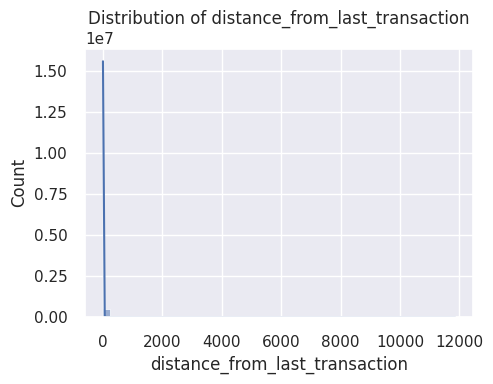

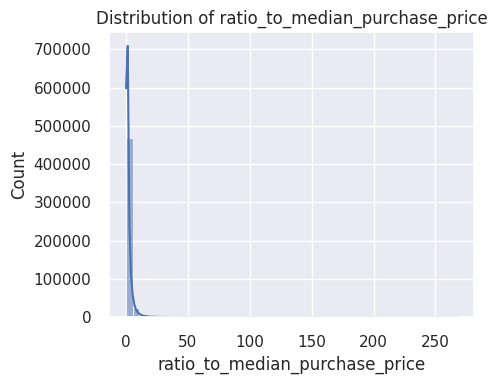

In [ ]:
# Univariate distributions for continuous features
num_cols = ["distance_from_home",
            "distance_from_last_transaction",
            "ratio_to_median_purchase_price"]

for col in num_cols:
    plt.figure(figsize=(5, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.savefig(f"figures/hist_{col}.png", dpi=150)
    plt.show()

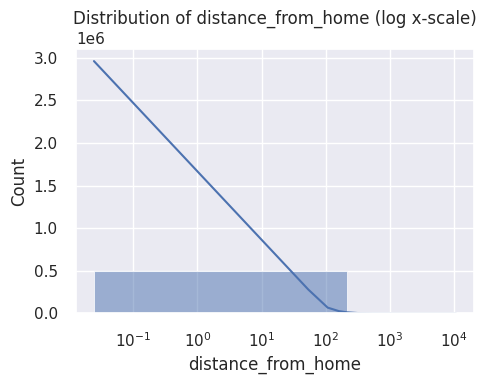

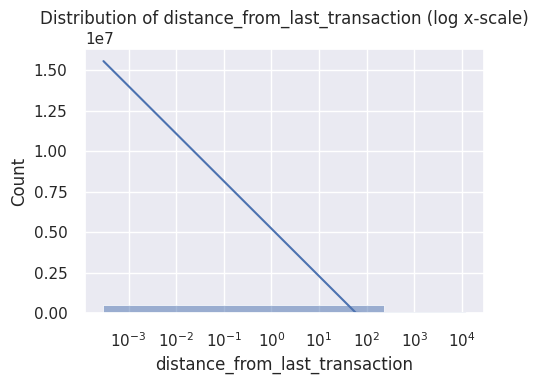

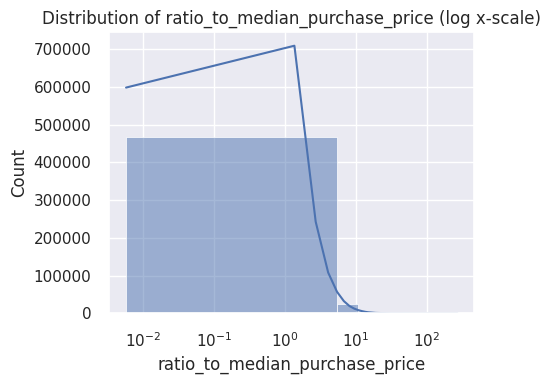

In [ ]:
# Log-scale histograms for skewed features
for col in num_cols:
    plt.figure(figsize=(5, 4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.xscale("log")
    plt.title(f"Distribution of {col} (log x-scale)")
    plt.tight_layout()
    plt.savefig(f"figures/hist_log_{col}.png", dpi=150)
    plt.show()

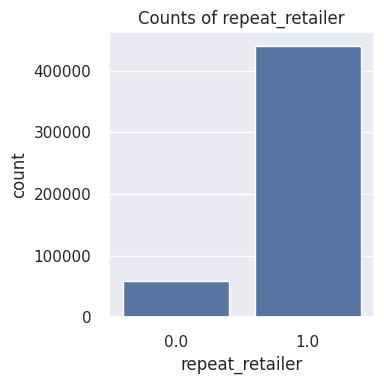

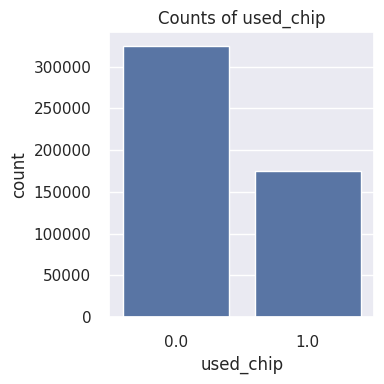

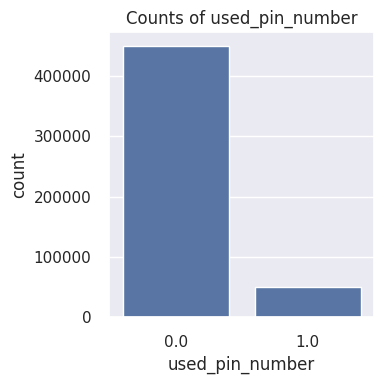

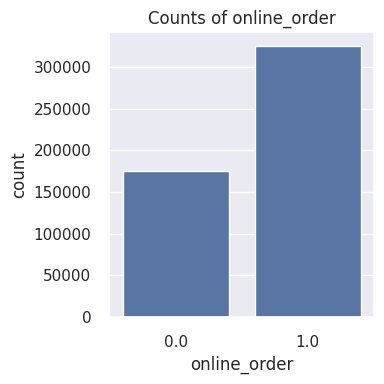

In [ ]:
# Binary feature distributions
bin_cols = ["repeat_retailer", "used_chip", "used_pin_number", "online_order"]

for col in bin_cols:
    plt.figure(figsize=(4, 4))
    sns.countplot(x=col, data=df)
    plt.title(f"Counts of {col}")
    plt.tight_layout()
    plt.savefig(f"figures/count_{col}.png", dpi=150)
    plt.show()

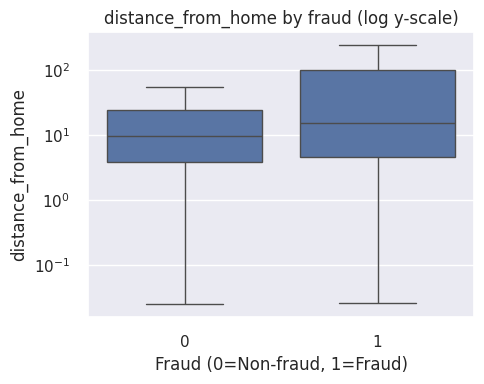

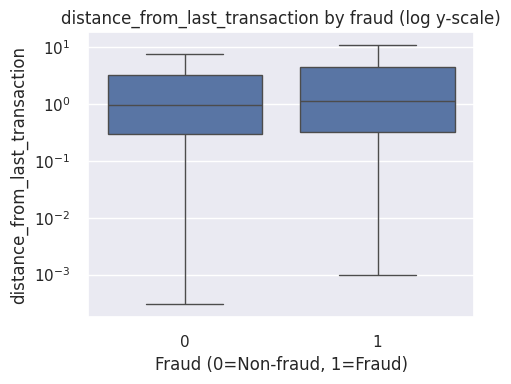

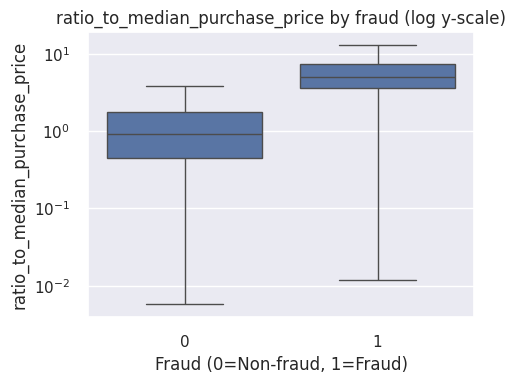

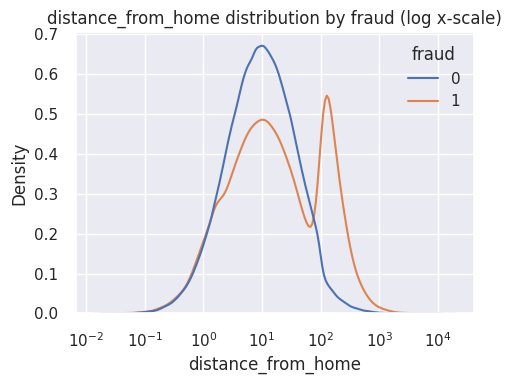

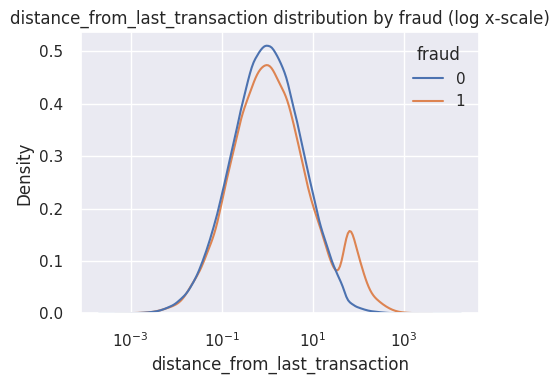

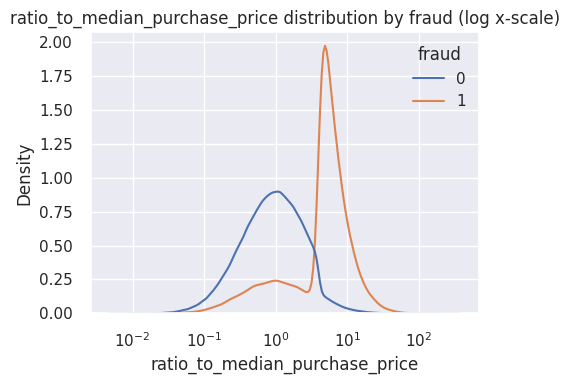

In [ ]:
# Continuous features vs fraud
for col in num_cols:
    plt.figure(figsize=(5, 4))
    sns.boxplot(x="fraud", y=col, data=df, showfliers=False)
    plt.yscale("log")
    plt.title(f"{col} by fraud (log y-scale)")
    plt.xlabel("Fraud (0=Non-fraud, 1=Fraud)")
    plt.tight_layout()
    plt.savefig(f"figures/box_{col}_by_fraud.png", dpi=150)
    plt.show()

for col in num_cols:
    plt.figure(figsize=(5, 4))
    sns.kdeplot(data=df, x=col, hue="fraud", common_norm=False, log_scale=True)
    plt.title(f"{col} distribution by fraud (log x-scale)")
    plt.tight_layout()
    plt.savefig(f"figures/kde_{col}_by_fraud.png", dpi=150)
    plt.show()

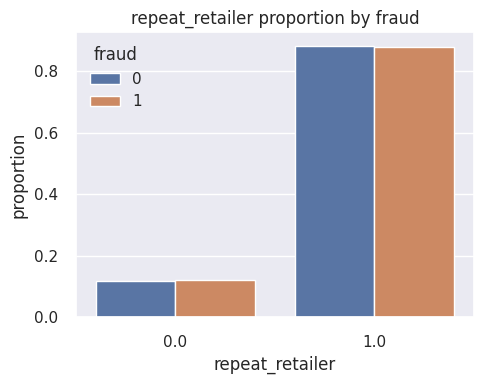

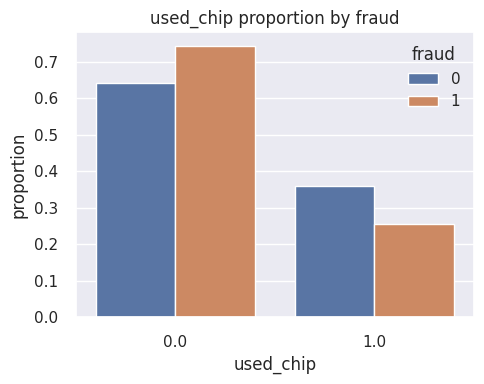

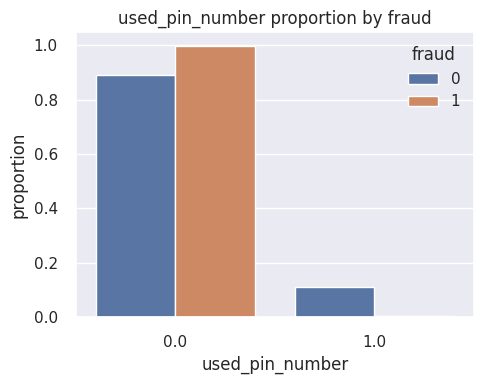

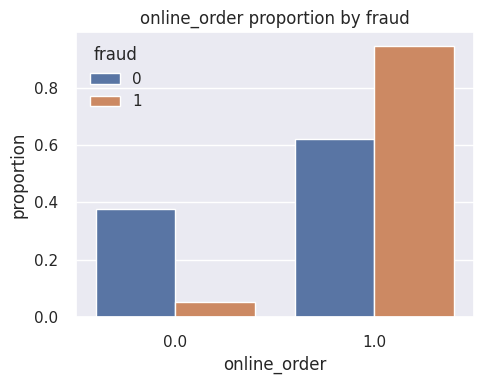

In [ ]:
# Categorical features vs fraud
for col in ["repeat_retailer", "used_chip", "used_pin_number", "online_order"]:
    plt.figure(figsize=(5, 4))
    prop_df = (
        df.groupby("fraud")[col]
          .value_counts(normalize=True)
          .rename("proportion")
          .reset_index()
    )
    sns.barplot(x=col, y="proportion", hue="fraud", data=prop_df)
    plt.title(f"{col} proportion by fraud")
    plt.tight_layout()
    plt.savefig(f"figures/bar_{col}_by_fraud.png", dpi=150)
    plt.show()

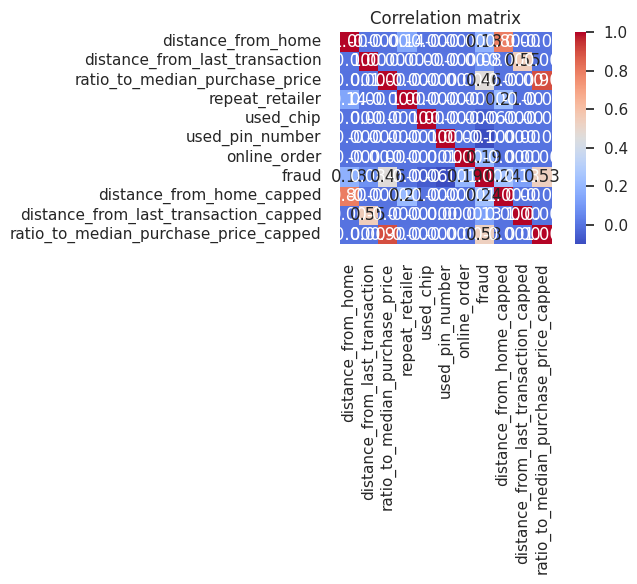

,fraud
fraud,1.000000
ratio_to_median_purchase_price_capped,0.533778
ratio_to_median_purchase_price,0.458875
distance_from_home_capped,0.235648
online_order,0.192144
distance_from_home,0.182472
distance_from_last_transaction_capped,0.125776
distance_from_last_transaction,0.084206
repeat_retailer,-0.003191
used_chip,-0.060981


In [ ]:
# Correlation matrix
plt.figure(figsize=(8, 6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation matrix")
plt.tight_layout()
plt.savefig("figures/corr_matrix.png", dpi=150)
plt.show()

corr["fraud"].sort_values(ascending=False)

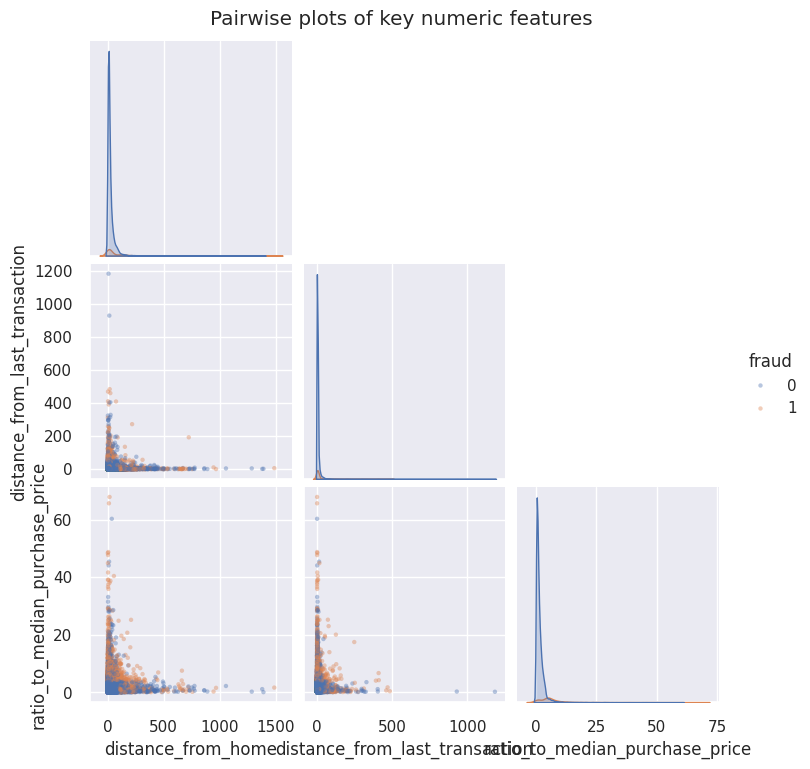

In [ ]:
# Pairplot on a sample
sample = df.sample(n=20000, random_state=42)

sns.pairplot(
    sample,
    vars=["distance_from_home",
          "distance_from_last_transaction",
          "ratio_to_median_purchase_price"],
    hue="fraud",
    corner=True,
    plot_kws={"alpha": 0.4, "s": 10, "edgecolor": "none"}
)
plt.suptitle("Pairwise plots of key numeric features", y=1.02)
plt.savefig("figures/pairplot_key_features.png", dpi=150)
plt.show()

In [ ]:
# Feature engineering
X = df[["distance_from_home",
        "distance_from_last_transaction",
        "ratio_to_median_purchase_price",
        "repeat_retailer",
        "used_chip",
        "used_pin_number",
        "online_order"]].copy()
y = df["fraud"]

# Log transforms of skewed continuous features
X["log_distance_from_home"] = np.log1p(X["distance_from_home"])
X["log_distance_from_last_transaction"] = np.log1p(X["distance_from_last_transaction"])
X["log_ratio_to_median_purchase_price"] = np.log1p(X["ratio_to_median_purchase_price"])

# Interaction features
X["online_and_far"] = X["online_order"] * X["log_distance_from_home"]
X["high_ratio_online"] = X["online_order"] * X["log_ratio_to_median_purchase_price"]

X.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,log_distance_from_home,log_distance_from_last_transaction,log_ratio_to_median_purchase_price,online_and_far,high_ratio_online
0,3.660608,0.109027,4.304168,1.0,0.0,0.0,1.0,1.539146,0.103483,1.668493,1.539146,1.668493
1,0.793127,1.554017,0.734684,0.0,0.0,0.0,1.0,0.583961,0.937667,0.550825,0.583961,0.550825
2,1.446629,1.060293,0.621182,0.0,0.0,0.0,1.0,0.894711,0.722848,0.483156,0.894711,0.483156
3,1.323360,0.468005,0.425015,0.0,1.0,0.0,0.0,0.843014,0.383904,0.354183,0.000000,0.000000
4,9.729656,12.446111,4.245820,1.0,1.0,0.0,1.0,2.373011,2.598690,1.657432,2.373011,1.657432


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

num_features = ["distance_from_home",
                "distance_from_last_transaction",
                "ratio_to_median_purchase_price",
                "log_distance_from_home",
                "log_distance_from_last_transaction",
                "log_ratio_to_median_purchase_price"]

scaler = StandardScaler()
X_train[num_features] = scaler.fit_transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Classification report:\n", classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.96     91249
           1       0.55      0.95      0.69      8751

    accuracy                           0.93    100000
   macro avg       0.77      0.94      0.83    100000
weighted avg       0.96      0.93      0.94    100000

ROC AUC: 0.9796025979056286
Confusion matrix:
 [[84375  6874]
 [  472  8279]]


## Summary and next steps

The EDA shows that fraud is relatively rare but present at a workable rate for modeling. Fraudulent transactions tend to be farther from home and the last transaction, have higher ratios to the median purchase price, are more likely online, and less likely to use chip or PIN.

A baseline logistic regression model with simple feature engineering provides an initial benchmark. Next steps could include trying tree‑based models (Random Forest, Gradient Boosting), tuning decision thresholds for better recall on the fraud class, and exploring additional features or time‑based patterns.
